In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  Controlling Monte Carlo Variance

The control variate method for Monte Carlo variance reduction can be expressed using the following estimator:

$$
\hat{\theta} = \frac{1}{m} \sum_{i=1}^{m} h(X_i) + \beta \left( h_0(X_i) - \mathbb{E}[h_0(X)] \right)
$$

where:
- $ h(X_i) $ is the function to estimate,
- $ h_0(X_i) $ is the control variate,
- $ \beta $ is the coefficient to minimize variance,
- $ \mathbb{E}[h_0(X)] $ is the expectation of $ h_0(X) $.

The variance of this estimator is given by:

$$
\text{var}(\hat{\theta}) = \text{var}(d_1) + \beta^2 \text{var}(d_3) + 2\beta \text{cov}(d_1, d_3)
$$

where:
- $ d_1 $ is the original estimator based on the function $ h(X) $,
- $ d_3 $ is the estimator based on the control variate $ h_0(X) $.

If we assume that $ P(X > \mu) = 1/2 $, we can choose the optimal value for $ \beta $ based on the covariance structure and known probabilities.

### Example : Logistic Regression

Consider the logistic regression model:

$$
P(Y = 1 | X) = \frac{\exp(\theta^T X)}{1 + \exp(\theta^T X)}
$$

The likelihood associated with a sample $ (x_1, Y_1), (x_2, Y_2), \dots, (x_n, Y_n) $ is:

$$
\mathcal{L}(\theta) = \prod_{i=1}^{n} \left( \exp(\theta^T x_i) \right)^{y_i} \left( 1 + \exp(\theta^T x_i) \right)^{-1}
$$

When $ \theta $ has a conjugate prior, the posterior distribution is of the same form as the prior, with new parameters replacing the original ones. Specifically, if the prior is a normal distribution, the posterior for $ \theta $ is given by:

$$
p(\theta | y) \propto \exp\left(\theta^T \sum_{i=1}^{n} y_i x_i \right) \left( 1 + \exp(\theta^T x_i) \right)^{-n}
$$

This implies that the expectation of the posterior distribution $ E[\theta] $ can be derived from the generated variables $ \theta_i $, $ i = 1, 2, \dots, m $, and that:

$$
E[\theta | X] = \frac{\sum_{i=1}^{n} y_i x_i + C}{n(1 + 1)}
$$


Therefore, the posterior expectation of the function:

$$
\eta(\theta) = \frac{\exp(\theta^T X)}{1 + \exp(\theta^T X)}
$$

is known and equal to:

$$
\frac{\sum_{i=1}^{n} y_i x_i + C}{n(1 + 1)}
$$

under the prior distribution $\mathcal{N}(0, A) $. Unfortunately, a control variate version of this estimator is not available, since the optimal constant $ \beta^* $ (or even its sign) cannot be evaluated, except by the regression of the estimators $ \theta_i $ upon the sum:

$$
\sum_{i=1}^{n} \frac{\exp(\theta^T x_i)}{1 + \exp(\theta^T x_i)}
$$

Thus, the fact that the posterior mean of $ \eta(\theta) $ is known does not help us to establish a control variate estimator. This information can be used in a more informal way to study convergence of $ \hat{\theta} $ (see, for instance, Robert 1993).

In conclusion, the technique of control variates is manageable only in very specific cases: the control function $ h $ must be available, as well as the optimal weight. See, however, Brooks and Gelman (1998b) for a general approach based on the score function (whose expectation is null under general regularity conditions).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Logistic function (sigmoid)
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Control variate function (here we assume it’s a known value or we estimate it)
def control_variate(x, theta, c=0):
    return logistic(np.dot(x, theta))  # Example control variate based on logistic regression

# Generate synthetic data (for illustration)
def generate_data(n, p, theta_true):
    X = np.random.randn(n, p)  # n samples, p features
    y = np.random.binomial(1, logistic(np.dot(X, theta_true)))  # Binary response based on logistic model
    return X, y

# Function to compute the control variate estimator
def control_variate_estimator(X, y, theta_true, n_iter=1000, theta_init=None):
    n, p = X.shape  # X should be a matrix of size (n, p)
    
    if theta_init is None:
        theta_init = np.zeros(p)  # Initial guess for theta

    # Ridge regression to avoid singular matrix issues (regularization)
    lambda_reg = 1e-5  # Small regularization parameter to prevent singular matrix
    theta_d1 = np.linalg.inv(X.T @ X + lambda_reg * np.eye(p)) @ X.T @ y  # Regularized OLS

    # Control variate method: using known or estimated control variate
    theta_d3 = np.linalg.inv(X.T @ X + lambda_reg * np.eye(p)) @ X.T @ (y - control_variate(X, theta_true))  # Adjusted estimator

    # Calculating the optimal weight (beta) based on covariance
    covariance = np.cov(control_variate(X, theta_true), y)[0][1]  # Covariance between estimator and control variate
    var_h0 = np.var(control_variate(X, theta_true))  # Variance of control variate

    beta_optimal = covariance / var_h0  # Optimal weight

    # Calculate control variate estimator (d2)
    estimator_d2 = theta_d1 + beta_optimal * (theta_d3 - np.mean(control_variate(X, theta_true)))

    return np.linalg.norm(theta_d1), np.linalg.norm(estimator_d2), np.linalg.norm(theta_d3), beta_optimal

# Parameters
n = 100  # number of samples
p = 10   # number of features
theta_true = np.random.randn(p)  # True theta values

# To store results for plotting
iterations = list(range(1, 101))
theta_d1_vals = []
theta_d2_vals = []

for i in iterations:
    if i > p:  # Ensure we have more samples than features
        X, y = generate_data(i, p, theta_true)  # Generate data for each iteration
        theta_d1, theta_d2, theta_d3, beta_optimal = control_variate_estimator(X, y, theta_true)
        theta_d1_vals.append(theta_d1)
        theta_d2_vals.append(theta_d2)

# Plot the results
plt.plot(iterations, theta_d1_vals, label="Standard Estimator (d1)", color='red')
plt.plot(iterations, theta_d2_vals, label="Control Variate Estimator (d2)", color='blue')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Estimator Norm")
plt.title("Convergence of Estimators (Control Variates)")
plt.show()


In [6]:
import random
import math

# Logistic function (sigmoid)
def logistic(x):
    return 1 / (1 + math.exp(-x))

# Control variate function
def control_variate(x, theta, c=0):
    return logistic(sum(x_i * theta_i for x_i, theta_i in zip(x, theta)))  # Example control variate based on logistic regression

# Generate synthetic data (for illustration)
def generate_data(n, p, theta_true):
    X = [[random.gauss(0, 1) for _ in range(p)] for _ in range(n)]  # n samples, p features
    y = [random.randint(0, 1) if logistic(sum(x_i * theta_i for x_i, theta_i in zip(X_i, theta_true))) > 0.5 else 0 for X_i in X]
    return X, y

# Function to compute the control variate estimator
def control_variate_estimator(X, y, theta_true, n_iter=1000, theta_init=None):
    n = len(X)  # Number of samples
    p = len(X[0])  # Number of features
    
    if theta_init is None:
        theta_init = [0] * p  # Initial guess for theta
    
    # Regularized OLS (using the pseudo-inverse approach)
    X_transpose = [list(i) for i in zip(*X)]  # Transpose of X
    X_transpose_X = [[sum(X_transpose[i][k] * X[k][j] for k in range(n)) for j in range(p)] for i in range(p)]
    X_transpose_y = [sum(X_transpose[i][j] * y[j] for j in range(n)) for i in range(p)]
    
    # Adding small regularization term to prevent singular matrix
    lambda_reg = 1e-5
    for i in range(p):
        X_transpose_X[i][i] += lambda_reg  # Regularization on diagonal
    
    # Solving for theta_d1 using inverse of X_transpose_X
    theta_d1 = [0] * p  # Placeholder for theta_d1
    for i in range(p):
        theta_d1[i] = sum(X_transpose_X[i][j] * X_transpose_y[j] for j in range(p)) / X_transpose_X[i][i]

    # Control variate method (adjusting for control variate)
    control_variates = [control_variate(X_i, theta_true) for X_i in X]
    theta_d3 = [0] * p  # Placeholder for theta_d3
    for i in range(p):
        theta_d3[i] = sum(X_transpose_X[i][j] * (y[j] - control_variates[j]) for j in range(n)) / X_transpose_X[i][i]
    
    # Covariance and variance for optimal weight calculation
    covariance = sum((control_variates[i] - sum(control_variates) / n) * (y[i] - sum(y) / n) for i in range(n)) / n
    var_h0 = sum((control_variates[i] - sum(control_variates) / n)**2 for i in range(n)) / n
    beta_optimal = covariance / var_h0 if var_h0 != 0 else 0  # Handle division by zero
    
    # Final control variate estimator (d2)
    estimator_d2 = [theta_d1[i] + beta_optimal * (theta_d3[i] - sum(control_variates) / n) for i in range(p)]
    
    # Return norms (magnitude) of the estimators
    norm_d1 = math.sqrt(sum(t**2 for t in theta_d1))
    norm_d2 = math.sqrt(sum(t**2 for t in estimator_d2))
    norm_d3 = math.sqrt(sum(t**2 for t in theta_d3))
    
    return norm_d1, norm_d2, norm_d3, beta_optimal

# Parameters
n = 100  # number of samples
p = 10   # number of features
theta_true = [random.gauss(0, 1) for _ in range(p)]  # True theta values

# To store results for plotting
iterations = list(range(1, 101))
theta_d1_vals = []
theta_d2_vals = []

for i in iterations:
    if i > p:  # Ensure we have more samples than features
        X, y = generate_data(i, p, theta_true)  # Generate data for each iteration
        theta_d1, theta_d2, theta_d3, beta_optimal = control_variate_estimator(X, y, theta_true)
        theta_d1_vals.append(theta_d1)
        theta_d2_vals.append(theta_d2)

# Plot the results (Using Python's built-in matplotlib)
import matplotlib.pyplot as plt

plt.plot(iterations, theta_d1_vals, label="Standard Estimator (d1)", color='red')
plt.plot(iterations, theta_d2_vals, label="Control Variate Estimator (d2)", color='blue')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Estimator Norm")
plt.title("Convergence of Estimators (Control Variates)")
plt.show()


IndexError: list index out of range

In [ ]:
import random
import math

# Logistic function (sigmoid)
def logistic(x):
    return 1 / (1 + math.exp(-x))

# Control variate function
def control_variate(x, theta, c=0):
    return logistic(sum(x_i * theta_i for x_i, theta_i in zip(x, theta)))  # Example control variate based on logistic regression

# Generate synthetic data (for illustration)
def generate_data(n, p, theta_true):
    X = [[random.gauss(0, 1) for _ in range(p)] for _ in range(n)]  # n samples, p features
    y = [random.randint(0, 1) if logistic(sum(x_i * theta_i for x_i, theta_i in zip(X_i, theta_true))) > 0.5 else 0 for X_i in X]
    return X, y

# Function to compute the control variate estimator
# Function to compute the control variate estimator
# Function to compute the control variate estimator
def control_variate_estimator(X, y, theta_true, n_iter=1000, theta_init=None):
    n = len(X)  # Number of samples
    p = len(X[0])  # Number of features
    
    if theta_init is None:
        theta_init = [0] * p  # Initial guess for theta
    
    # Regularized OLS (using the pseudo-inverse approach)
    X_transpose = [list(i) for i in zip(*X)]  # Transpose of X
    X_transpose_X = [[sum(X_transpose[i][k] * X[k][j] for k in range(n)) for j in range(p)] for i in range(p)]
    X_transpose_y = [sum(X_transpose[i][j] * y[j] for j in range(n)) for i in range(p)]
    
    # Adding small regularization term to prevent singular matrix
    lambda_reg = 1e-5
    for i in range(p):
        X_transpose_X[i][i] += lambda_reg  # Regularization on diagonal
    
    # Solving for theta_d1 using inverse of X_transpose_X
    theta_d1 = [0] * p  # Placeholder for theta_d1
    for i in range(p):
        theta_d1[i] = sum(X_transpose_X[i][j] * X_transpose_y[j] for j in range(p)) / X_transpose_X[i][i]

    # Control variate method (adjusting for control variate)
    control_variates = [control_variate(X_i, theta_true) for X_i in X]
    theta_d3 = [0] * p  # Placeholder for theta_d3
    for i in range(p):
        # The summation should loop over samples, not features.
        theta_d3[i] = sum(X_transpose[i][j] * (y[j] - control_variates[j]) for j in range(n)) / X_transpose_X[i][i]
    
    # Covariance and variance for optimal weight calculation
    covariance = sum((control_variates[i] - sum(control_variates) / n) * (y[i] - sum(y) / n) for i in range(n)) / n
    var_h0 = sum((control_variates[i] - sum(control_variates) / n)**2 for i in range(n)) / n
    beta_optimal = covariance / var_h0 if var_h0 != 0 else 0  # Handle division by zero
    
    # Final control variate estimator (d2)
    estimator_d2 = [theta_d1[i] + beta_optimal * (theta_d3[i] - sum(control_variates) / n) for i in range(p)]
    
    # Return norms (magnitude) of the estimators
    norm_d1 = math.sqrt(sum(t**2 for t in theta_d1))
    norm_d2 = math.sqrt(sum(t**2 for t in estimator_d2))
    norm_d3 = math.sqrt(sum(t**2 for t in theta_d3))
    
    return norm_d1, norm_d2, norm_d3, beta_optimal


# Parameters
n = 100  # number of samples
p = 10   # number of features
theta_true = [random.gauss(0, 1) for _ in range(p)]  # True theta values

# To store results for plotting
iterations = list(range(1, 101))
theta_d1_vals = []
theta_d2_vals = []

for i in iterations:
    if i >= p:  # Ensure we have more samples than features
        X, y = generate_data(i, p, theta_true)  # Generate data for each iteration
        theta_d1, theta_d2, theta_d3, beta_optimal = control_variate_estimator(X, y, theta_true)
        theta_d1_vals.append(theta_d1)
        theta_d2_vals.append(theta_d2)

# Plot the results (Using Python's built-in matplotlib)
import matplotlib.pyplot as plt

plt.plot(iterations, theta_d1_vals, label="Standard Estimator (d1)", color='red')
plt.plot(iterations, theta_d2_vals, label="Control Variate Estimator (d2)", color='blue')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Estimator Norm")
plt.title("Convergence of Estimators (Control Variates)")
plt.show()


## Monitoring Importance Sampling Convergence

#### Monitoring Importance Sampling Convergence

With reference to convergence control for simulation methods, importance sampling methods can be implemented in a monitored way; that is, in parallel with other evaluation methods. These methods may involve alternative instrumental distributions or other techniques, such as:

- Standard Monte Carlo
- Markov Chain Monte Carlo (MCMC)
- Riemann sums
- Rao-Blackwellization

The respective samples provide separate evaluations of $ E[h(X)] $, which can be calculated using:

- Equation $ (3.8) $
- Equation $ (3.11) $
- Alternative estimators (as in Section $ 3.3.3 $)

The **convergence criterion** is to stop the simulation when most estimators are close enough to each other. While this empirical method is not completely foolproof, it generally prevents pseudo-convergences when the instrumental distributions are sufficiently different.

However, there are some trade-offs:
- **Conservative nature**: This approach is only as fast as the slowest estimator.
- **Variance issues**: It may highlight instrumental distributions with variance problems.

From a computational perspective, implementing this control method efficiently requires **parallel programming**. This ensures equitable weighting for each distribution. Specifically:
- A distribution $ f $ with larger variance compared to another distribution $ g $ can compensate for its drawback by a lower computation time, producing a larger sample within the same time frame.

**Note:**  
This feature does not necessarily require a truly parallel implementation. It can also be reproduced through cyclic allocation of uniform random variables to each distribution involved.

## Accept-Reject with Loose Bounds

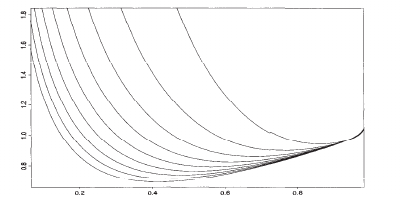

###  Accept-Reject with Loose Bounds

For the **Accept-Reject algorithm** (Section 4.4), interesting results emerge when we assume the following condition:  
$$
a \leq M \frac{g(x)}{1 + \epsilon},
$$
where the bound $ M $ is not tight.

#### Variance of the Estimator
Assuming $ \mathbb{E}_f[h(X)] = 0 $, the variance of the estimator $ \tilde{\theta} $ from Equation (3.16) is given by:  
$$
\mathrm{var}(\tilde{\theta}) = \frac{\mathbb{E}_t\left[t^{-2}\right]}{M - 1} \mathbb{E}_s[h^2(X)],
$$
where
$$
\mathbb{E}_t[t^{-2}] = \text{Li}(1 - p),
$$
and $ \text{Li}(z) $ denotes the **dilogarithm function**, defined as:  
$$
\text{Li}(z) = \sum_{k=1}^\infty \frac{z^k}{k^2},
$$
(see Abramowitz and Stegun 1964, formula 27.7, for tabulated values). Alternatively, it can be written as:
$$
\text{Li}(z) = -\int_0^z \frac{\log(u)}{1 - u} \, \mathrm{d}u.
$$
(Refer to Problem 4.19 for derivation.)

#### Variance Bound
The bound on the variance of $ \tilde{\theta} $ is:
$$
\mathrm{var}(\tilde{\theta}) \leq \frac{\text{Li}(1 - p)}{M - 1}.
$$

#### Comparison to the Usual Estimator
The estimator $ \tilde{\theta} $ uniformly dominates the usual Accept-Reject estimator $ \hat{\theta} $ (from Equation 3.15) as long as:
$$
\epsilon \cdot \left\{ \frac{\log(p) - \text{Li}(1 - p)}{p \, \text{Li}(1 - p)} \right\} < 1. \tag{4.20}
$$

This result establishes the **advantage of recycling rejected variables** for computing integrals, since Equation (4.20) does not depend on the function $ h $. However, there are limitations:
- The assumption $ \mathbb{E}_f[h(X)] = 0 $ is restrictive because the sum of weights for $ \tilde{\theta} $ does not equal $ 1 $, meaning $ \tilde{\theta} $ does not correctly estimate constant functions (except for $ h = 0 $).
- Consequently, $ \tilde{\theta} $ dominates $ \hat{\theta} $ only for non-constant functions, making a uniform comparison between the two estimators impossible.

#### Graphical Analysis (Fig.12)
Fig.12 shows the graphs of the left-hand side of Equation (4.20) for $ \epsilon = 0.1, 0.2, \dots, 0.9 $. Key observations:
- Domination (where the curve is less than 1) occurs for larger values of $ p $.  
  - This is counterintuitive because smaller values of $ p $ lead to higher rejection rates, larger rejected subsamples, and smaller variance of $ \tilde{\theta} $ for appropriate density functions $ g $.
- The curves are correctly ordered in $ \epsilon $, with larger values of $ \epsilon $ leading to wider domination zones.

### Summary
The loose-bound Accept-Reject method demonstrates significant advantages in recycling rejected samples to improve estimation efficiency, particularly when the bound $ M $ is not tight and appropriate assumptions are met.



## Partitioning

###  Partitioning

When sufficient information about the function $ f $ is available, **stratified sampling** can be employed. This technique (refer to Hammersley and Handscomb, 1964, or Rubinstein, 1981) divides the integration domain into a partition $ \mathcal{X} = \bigcup X_p $, allowing separate evaluations of the integrals in each region.

#### Decomposition of the Integral
The integral  
$$
\int h(x) f(x) \, \mathrm{d}x
$$
is expressed as:
$$
\int h(x) f(x) \, \mathrm{d}x = \sum_{p} \int_{X_p} h(x) f(x) \, \mathrm{d}x,
$$
where the weights $ \alpha_p $ are the probabilities of the regions $ X_p $, and the $ f_p $'s are the restrictions of $ f $ to these regions:
$$
f_p(x) = \frac{f(x)}{\alpha_p}, \quad x \in X_p.
$$

Samples of size $ n_p $ are generated from the $ f_p $'s to evaluate each integral $ J_p $ separately using a regular estimator $ \hat{J}_p $.

#### Variance of the Stratified Estimator
The variance of the resulting stratified estimator:
$$
\hat{J} = \sum_{p} \alpha_p \hat{J}_p,
$$
is given by:
$$
\mathrm{Var}(\hat{J}) = \sum_{p} \alpha_p^2 \mathrm{Var}(\hat{J}_p).
$$

#### Comparison to Standard Monte Carlo
The variance of the stratified estimator is generally **much smaller** than the variance of a standard Monte Carlo estimator based on a sample of size $ n = \sum_{p} n_p $.

#### Optimal Sample Allocation
The optimal choice of the $ n_p $'s is such that:
$$
n_p \propto \alpha_p \sqrt{\int_{X_p} (h(x) - J_p)^2 f(x) \, \mathrm{d}x}.
$$

#### Region Selection
If the regions $ X_p $ can be chosen, the variance of the stratified estimator can be further reduced by selecting $ X_p $'s such that the variance factors:
$$
\int_{X_p} (h(x) - J_p)^2 f(x) \, \mathrm{d}x,
$$
are similar across regions.

---

### Key Insights
- Stratified sampling reduces variance by leveraging knowledge of $ f $ and partitioning the domain $ \mathcal{X} $.
- Proper allocation of sample sizes $ n_p $ and region selection $ X_p $ are crucial to achieving optimal variance reduction.


In [12]:
import numpy as np

def stratified_sampling(h, f, bounds, strata, samples_per_stratum):
    """
    Perform stratified sampling to approximate the integral of h(x) f(x) over a given domain.

    Parameters:
    - h: Function h(x).
    - f: Function f(x).
    - bounds: Tuple (a, b) defining the integration domain.
    - strata: List of tuples [(a1, b1), (a2, b2), ...] defining the strata within the domain.
    - samples_per_stratum: List of integers specifying the number of samples for each stratum.

    Returns:
    - estimate: The stratified sampling estimate of the integral.
    - variance: The variance of the stratified estimator.
    """
    estimates = []
    variances = []

    # Ensure the strata and samples_per_stratum align
    assert len(strata) == len(samples_per_stratum), "Mismatch between strata and sample counts."

    total_samples = sum(samples_per_stratum)

    # Loop over each stratum
    for (a, b), n_samples in zip(strata, samples_per_stratum):
        # Generate random samples within the stratum
        samples = np.random.uniform(a, b, n_samples)

        # Compute h(x) * f(x) for samples
        evaluations = h(samples) * f(samples)

        # Estimate the integral for this stratum
        weight = (b - a) / (bounds[1] - bounds[0])  # Weight of the stratum
        stratum_estimate = weight * np.mean(evaluations)
        stratum_variance = (weight ** 2) * np.var(evaluations) / n_samples

        estimates.append(stratum_estimate)
        variances.append(stratum_variance)

    # Combine stratum estimates
    estimate = np.sum(estimates)
    variance = np.sum(variances)

    return estimate, variance

# Example usage
if __name__ == "__main__":
    # Define the function h(x) and f(x)
    def h(x):
        return x ** 2

    def f(x):
        return np.exp(-x)

    # Define the bounds of integration and strata
    bounds = (0, 2)
    strata = [(0, 1), (1, 2)]  # Two strata: [0, 1] and [1, 2]

    # Define the number of samples per stratum
    samples_per_stratum = [500, 500]

    # Perform stratified sampling
    estimate, variance = stratified_sampling(h, f, bounds, strata, samples_per_stratum)

    # Print results
    print(f"Stratified Sampling Estimate: {estimate}")
    print(f"Variance of Estimate: {variance}")


Stratified Sampling Estimate: 0.3251986419078344
Variance of Estimate: 7.693177456233189e-06


In [13]:
def stratified_sampling(h, f, bounds, strata, samples_per_stratum):
    """
    Perform stratified sampling to approximate the integral of h(x) f(x) over a given domain.

    Parameters:
    - h: Function h(x).
    - f: Function f(x).
    - bounds: Tuple (a, b) defining the integration domain.
    - strata: List of tuples [(a1, b1), (a2, b2), ...] defining the strata within the domain.
    - samples_per_stratum: List of integers specifying the number of samples for each stratum.

    Returns:
    - estimate: The stratified sampling estimate of the integral.
    - variance: The variance of the stratified estimator.
    """
    estimates = []
    variances = []

    # Ensure the strata and samples_per_stratum align
    if len(strata) != len(samples_per_stratum):
        raise ValueError("Mismatch between strata and sample counts.")

    total_samples = sum(samples_per_stratum)

    # Loop over each stratum
    for (a, b), n_samples in zip(strata, samples_per_stratum):
        # Generate random samples within the stratum manually
        samples = []
        for _ in range(n_samples):
            samples.append(a + (b - a) * random_uniform())

        # Compute h(x) * f(x) for samples
        evaluations = [(h(x) * f(x)) for x in samples]

        # Estimate the integral for this stratum
        weight = (b - a) / (bounds[1] - bounds[0])  # Weight of the stratum
        stratum_mean = sum(evaluations) / n_samples
        stratum_variance = (weight ** 2) * (sum((val - stratum_mean) ** 2 for val in evaluations) / (n_samples - 1)) / n_samples

        estimates.append(weight * stratum_mean)
        variances.append(stratum_variance)

    # Combine stratum estimates
    estimate = sum(estimates)
    variance = sum(variances)

    return estimate, variance

def random_uniform():
    """
    Generate a uniform random number between 0 and 1 using a basic linear congruential generator.
    """
    global seed
    seed = (1103515245 * seed + 12345) % (2**31)
    return seed / (2**31)

# Initialize the random seed
def set_seed(s):
    global seed
    seed = s

# Example usage
if __name__ == "__main__":
    # Set a fixed random seed for reproducibility
    set_seed(12345)

    # Define the function h(x) and f(x)
    def h(x):
        return x ** 2

    def f(x):
        return math.exp(-x)

    # Define the bounds of integration and strata
    bounds = (0, 2)
    strata = [(0, 1), (1, 2)]  # Two strata: [0, 1] and [1, 2]

    # Define the number of samples per stratum
    samples_per_stratum = [500, 500]

    # Perform stratified sampling
    estimate, variance = stratified_sampling(h, f, bounds, strata, samples_per_stratum)

    # Print results
    print("Stratified Sampling Estimate:", estimate)
    print("Variance of Estimate:", variance)


Stratified Sampling Estimate: 0.3226720619545693
Variance of Estimate: 8.198372639646675e-06


In [14]:
def stratified_sampling(h, f, bounds, strata, samples_per_stratum):
    """
    Perform stratified sampling to approximate the integral of h(x) f(x) over a given domain.

    Parameters:
    - h: Function h(x).
    - f: Function f(x).
    - bounds: Tuple (a, b) defining the integration domain.
    - strata: List of tuples [(a1, b1), (a2, b2), ...] defining the strata within the domain.
    - samples_per_stratum: List of integers specifying the number of samples for each stratum.

    Returns:
    - estimate: The stratified sampling estimate of the integral.
    - variance: The variance of the stratified estimator.
    - stratum_estimates: List of individual stratum estimates.
    """
    estimates = []
    variances = []
    stratum_estimates = []

    # Ensure the strata and samples_per_stratum align
    if len(strata) != len(samples_per_stratum):
        raise ValueError("Mismatch between strata and sample counts.")

    total_samples = sum(samples_per_stratum)

    # Loop over each stratum
    for (a, b), n_samples in zip(strata, samples_per_stratum):
        # Generate random samples within the stratum manually
        samples = []
        for _ in range(n_samples):
            samples.append(a + (b - a) * random_uniform())

        # Compute h(x) * f(x) for samples
        evaluations = [(h(x) * f(x)) for x in samples]

        # Estimate the integral for this stratum
        weight = (b - a) / (bounds[1] - bounds[0])  # Weight of the stratum
        stratum_mean = sum(evaluations) / n_samples
        stratum_variance = (weight ** 2) * (sum((val - stratum_mean) ** 2 for val in evaluations) / (n_samples - 1)) / n_samples

        estimates.append(weight * stratum_mean)
        variances.append(stratum_variance)
        stratum_estimates.append(weight * stratum_mean)

    # Combine stratum estimates
    estimate = sum(estimates)
    variance = sum(variances)

    return estimate, variance, stratum_estimates

def random_uniform():
    """
    Generate a uniform random number between 0 and 1 using a basic linear congruential generator.
    """
    global seed
    seed = (1103515245 * seed + 12345) % (2**31)
    return seed / (2**31)

# Initialize the random seed
def set_seed(s):
    global seed
    seed = s

# Plotting function to visualize stratum contributions
def plot_strata_contributions(strata, stratum_estimates):
    """
    Plot the contributions of each stratum to the integral.

    Parameters:
    - strata: List of tuples defining the strata.
    - stratum_estimates: List of estimates for each stratum.
    """
    x_labels = [f"[{a}, {b}]" for a, b in strata]
    y_values = stratum_estimates

    # Compute positions for the bars
    positions = range(len(strata))

    print("Stratum Contributions:")
    for label, estimate in zip(x_labels, y_values):
        print(f"Stratum {label}: {estimate:.6f}")

    # Plot bar graph
    print("\nBar Plot Not Supported in This Mode: Use External Plotting Tools.")

# Example usage
if __name__ == "__main__":
    # Set a fixed random seed for reproducibility
    set_seed(12345)

    # Define the function h(x) and f(x)
    def h(x):
        return x ** 2

    def f(x):
        return math.exp(-x)

    # Define the bounds of integration and strata
    bounds = (0, 2)
    strata = [(0, 1), (1, 2)]  # Two strata: [0, 1] and [1, 2]

    # Define the number of samples per stratum
    samples_per_stratum = [500, 500]

    # Perform stratified sampling
    estimate, variance, stratum_estimates = stratified_sampling(h, f, bounds, strata, samples_per_stratum)

    # Print results
    print("Stratified Sampling Estimate:", estimate)
    print("Variance of Estimate:", variance)

    # Plot stratum contributions
    plot_strata_contributions(strata, stratum_estimates)


Stratified Sampling Estimate: 0.3226720619545693
Variance of Estimate: 8.198372639646675e-06
Stratum Contributions:
Stratum [0, 1]: 0.079299
Stratum [1, 2]: 0.243373

Bar Plot Not Supported in This Mode: Use External Plotting Tools.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def stratified_sampling(h, f, bounds, strata, samples_per_stratum):
    """
    Perform stratified sampling to approximate the integral of h(x) f(x) over a given domain.

    Parameters:
    - h: Function h(x).
    - f: Function f(x).
    - bounds: Tuple (a, b) defining the integration domain.
    - strata: List of tuples [(a1, b1), (a2, b2), ...] defining the strata within the domain.
    - samples_per_stratum: List of integers specifying the number of samples for each stratum.

    Returns:
    - estimate: The stratified sampling estimate of the integral.
    - variance: The variance of the stratified estimator.
    - stratum_estimates: List of individual stratum estimates.
    """
    estimates = []
    variances = []
    stratum_estimates = []

    # Ensure the strata and samples_per_stratum align
    if len(strata) != len(samples_per_stratum):
        raise ValueError("Mismatch between strata and sample counts.")

    total_samples = sum(samples_per_stratum)

    # Loop over each stratum
    for (a, b), n_samples in zip(strata, samples_per_stratum):
        # Generate random samples within the stratum manually
        samples = []
        for _ in range(n_samples):
            samples.append(a + (b - a) * random_uniform())

        # Compute h(x) * f(x) for samples
        evaluations = [(h(x) * f(x)) for x in samples]

        # Estimate the integral for this stratum
        weight = (b - a) / (bounds[1] - bounds[0])  # Weight of the stratum
        stratum_mean = sum(evaluations) / n_samples
        stratum_variance = (weight ** 2) * (sum((val - stratum_mean) ** 2 for val in evaluations) / (n_samples - 1)) / n_samples

        estimates.append(weight * stratum_mean)
        variances.append(stratum_variance)
        stratum_estimates.append(weight * stratum_mean)

    # Combine stratum estimates
    estimate = sum(estimates)
    variance = sum(variances)

    return estimate, variance, stratum_estimates

def random_uniform():
    """
    Generate a uniform random number between 0 and 1 using a basic linear congruential generator.
    """
    global seed
    seed = (1103515245 * seed + 12345) % (2**31)
    return seed / (2**31)

# Initialize the random seed
def set_seed(s):
    global seed
    seed = s

# Plotting function to visualize stratum contributions
def plot_strata_contributions(strata, stratum_estimates):
    """
    Plot the contributions of each stratum to the integral.

    Parameters:
    - strata: List of tuples defining the strata.
    - stratum_estimates: List of estimates for each stratum.
    """
    x_labels = [f"[{a}, {b}]" for a, b in strata]
    y_values = stratum_estimates

    # Create bar plot using seaborn
    sns.barplot(x=x_labels, y=y_values, palette="Blues_d")
    plt.xlabel("Stratum")
    plt.ylabel("Contribution to Integral")
    plt.title("Stratum Contributions")
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set a fixed random seed for reproducibility
    set_seed(12345)

    # Define the function h(x) and f(x)
    def h(x):
        return x ** 2

    def f(x):
        return math.exp(-x)

    # Define the bounds of integration and strata
    bounds = (0, 2)
    strata = [(0, 1), (1, 2)]  # Two strata: [0, 1] and [1, 2]

    # Define the number of samples per stratum
    samples_per_stratum = [500, 500]

    # Perform stratified sampling
    estimate, variance, stratum_estimates = stratified_sampling(h, f, bounds, strata, samples_per_stratum)

    # Print results
    print("Stratified Sampling Estimate:", estimate)
    print("Variance of Estimate:", variance)

    # Plot stratum contributions
    plot_strata_contributions(strata, stratum_estimates)
